In [1]:
import llama
from llama import options as opts
from llama.api import enums
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import llama.timing.timer_utils as timer_utils
timer_utils.toggle_timer(True)

In [2]:
import llama.io.loaders
from llama.io.loaders.enums import LoaderType


In [3]:
parent_folder = "/gpfs/dfnt1/test/lamni/cSAXS_e18044_LamNI_201907/"
dat_file_path = os.path.join(parent_folder, "specES1", "dat-files", "tomography_scannumbers.txt")
parent_projection_folder = os.path.join(parent_folder, "analysis")

# # Load data - interactive
options = llama.io.loaders.LamniLoadOptions(
    loader_type=LoaderType.LAMNI_V1,
    selected_experiment_name="unlabeled",
    selected_sequences=[3],
    selected_metadata_list=["512x512_b0_MLc_Niter500_recons"],
    scan_start=2700,
    scan_end=2720,
)

lamni_data = llama.io.loaders.load_data_from_lamni_format(
    dat_file_path=dat_file_path,
    parent_projections_folder=parent_projection_folder,
    n_processes=int(mp.cpu_count() * 0.8),
    options=options,
)


User-provided loading options:
  loader_type: lamni_v1
  selected_experiment_name: unlabeled
  selected_metadata_list: ['512x512_b0_MLc_Niter500_recons']
  selected_sequences: [3]
  scan_start: 2700
  scan_end: 2720
5 scans have one or more projection files.
Use these settings to bypass user-selection on next load:
  selected_experiment_name="unlabeled",
  selected_sequences=[3],
  selected_metadata_list=['512x512_b0_MLc_Niter500_recons'],
  scan_start=2700,
  scan_end=2720,
Loading projections into list...


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:00<00:00, 21.90it/s]


Loading complete. Duration: 0.428389310836792


In [4]:
# You could update this so it can downsample
projection_array = llama.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
)

Fixing projections dimensions...


  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.14it/s]


Fixing projections dimensions...Completed
Converting list to array...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.74it/s]

Converting list to array..Completed


In [5]:
projection_array.shape

(5, 1984, 1536)

In [9]:
# Set device options for input downsampling, rotation, and shearing
def set_projection_options(
    rotation_angle,
    shear_angle,
    crop_horizontal_range,
    crop_vertical_range,
    horizontal_offset,
    vertical_offset,
    scale,
):
    n_gpus = 1
    device_options = opts.DeviceOptions(
        device_type=enums.DeviceType.GPU,
        gpu=opts.GPUOptions(
            chunking_enabled=True,
            chunk_length=4,
            n_gpus=n_gpus,
            gpu_indices=(5,),
        ),
    )
    projection_options = opts.ProjectionOptions(
        experiment=opts.ExperimentOptions(
            laminography_angle=61.108,
            sample_thickness=7e-6,
            pixel_size=lamni_data.pixel_size,
        ),
        input_processing=opts.ProjectionTransformOptions(
            rotation=opts.RotationOptions(
                enabled=True,
                angle=rotation_angle,
                device=device_options,
            ),
            shear=opts.ShearOptions(
                enabled=True,
                angle=shear_angle,
                device=device_options,
            ),
            crop=opts.CropOptions(
                enabled=True,
                horizontal_range=crop_horizontal_range,
                vertical_range=crop_vertical_range,
                horizontal_offset=horizontal_offset,
                vertical_offset=vertical_offset,
            ),
            downsample=opts.DownsampleOptions(
                enabled=True,
                scale=scale,
                device=device_options,
                use_gaussian_filter=True,
            ),
        ),
    )

    return projection_options


Fixing projections dimensions...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


Fixing projections dimensions...Completed
Converting list to array...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.45it/s]


Converting list to array..Completed


image_shear_fft: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.74it/s]


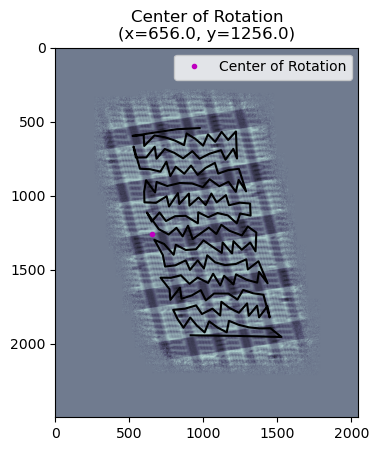

image_shear_fft: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 187.26it/s]


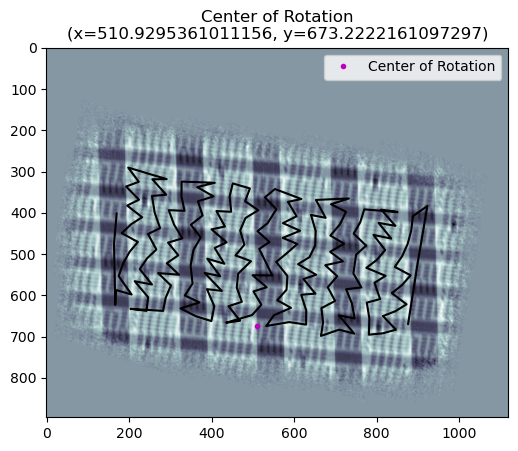

In [10]:
# Inputs
laminography_angle = 61.108
sample_thickness = 7e-6
center_of_rotation = np.array([1000, 400]) + 256
rotation_angle = 0#70  # 50#80  # -30
shear_angle = 0  # 30  # 1.296
# crop_horizontal_range, crop_vertical_range = 1984, 1536
crop_horizontal_range, crop_vertical_range = 1536 + 256, 1984 + 256
horizontal_offset = 128

# Convert projection dict to an array
projection_array = llama.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
    new_shape=(1984 + 512, 1536 + 512),
)
projection_array = llama.gpu_utils.pin_memory(projection_array)


# Show projections without any input processing
projection_options = set_projection_options(
    rotation_angle=0,
    shear_angle=0,
    crop_horizontal_range=0,
    crop_vertical_range=0,
    horizontal_offset=0,
    vertical_offset=0,
    scale=1,
)

complex_projections = llama.ComplexProjections(
    projections=projection_array,
    angles=lamni_data.angles,
    scan_numbers=lamni_data.scan_numbers,
    options=projection_options,
    probe_positions=list(lamni_data.probe_positions.values()),
    probe=lamni_data.probe,
    center_of_rotation=center_of_rotation,
    skip_pre_processing=False,
)

i = 0
complex_projections.show_center_of_rotation(
    plot_sum_of_projections=False, proj_idx=i, show_plot=False
)
complex_projections.probe_positions.plot_positions(index=i, color="k")
plt.show()

# Show projections with input processing
projection_options = set_projection_options(
    rotation_angle=70,
    shear_angle=25,
    crop_horizontal_range=1536 + 256,
    crop_vertical_range=1984 + 256,
    horizontal_offset=123,
    vertical_offset=40,
    scale=2,
)

complex_projections = llama.ComplexProjections(
    projections=projection_array,
    angles=lamni_data.angles,
    scan_numbers=lamni_data.scan_numbers,
    options=projection_options,
    probe_positions=list(lamni_data.probe_positions.values()),
    probe=lamni_data.probe,
    center_of_rotation=center_of_rotation,
    skip_pre_processing=False,
)

i = 0
complex_projections.show_center_of_rotation(
    plot_sum_of_projections=False, proj_idx=i, show_plot=False
)
complex_projections.probe_positions.plot_positions(index=i, color="k")
plt.show()


Note that the chosen center of rotation point and the probe positions are properly transformed